In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

<h1>Data preparation and Preprocessing pipeline</h1>

1. read the data from csv file and display it

In [2]:
review_df = pd.read_csv("reviews.csv")

In [3]:
review_df

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...
2,1178162,5003196,2013-06-06,6449554,Sebastian,We really enjoyed our stay at Islams house. Fr...
3,1178162,5150351,2013-06-15,2215611,Marine,The room was nice and clean and so were the co...
4,1178162,5171140,2013-06-16,6848427,Andrew,Great location. Just 5 mins walk from the Airp...
...,...,...,...,...,...,...
68270,7462268,80537457,2016-06-18,22034145,Antonio,Joe y su mujer son encantadores. La habitación...
68271,7462268,83640094,2016-07-03,40052513,Steve,Joe was on his way to Jamaica to be married! o...
68272,7462268,85797088,2016-07-13,77129134,Nick,The room was very clean as were the bathrooms ...
68273,7462268,97264637,2016-08-26,15799803,Vid,Staying in Lower Allston at Joe and Nancy's pl...


In [4]:
review_df['comments'] = review_df['comments'].astype(str)

In [5]:
review_df.dropna(inplace=True)
review_df.date = pd.to_datetime(review_df.date)
review_df.info()
review_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68275 entries, 0 to 68274
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   listing_id     68275 non-null  int64         
 1   id             68275 non-null  int64         
 2   date           68275 non-null  datetime64[ns]
 3   reviewer_id    68275 non-null  int64         
 4   reviewer_name  68275 non-null  object        
 5   comments       68275 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 3.6+ MB


listing_id       0
id               0
date             0
reviewer_id      0
reviewer_name    0
comments         0
dtype: int64

In [6]:
import langdetect

def is_english(text):
    try:
        return langdetect.detect(text) == "en"
    except:
        return False

review_df = review_df[review_df["comments"].apply(is_english)]
review_df = review_df[review_df['comments'].apply(lambda x: len(x.split()) >= 5)]

In [7]:
def clean_comment(text):
    text = re.sub(r"[^\w\s]", "", text).lower()
    tokens = text.split()
    stopwords = ["a", "an", "the", "and", "but", "if", "or", "because", "as", "what", "which", "this", "that", "these", "those", "then", "just", "so", "than", "such", "both", "through", "about", "for", "is", "of", "while", "during", "to", "What", "Which", "Who", "How", "Whom", "The"]
    tokens = [token for token in tokens if token not in stopwords]
    
    # Return the cleaned and preprocessed review text
    return " ".join(tokens)

In [8]:
review_df["comments"] = review_df["comments"].apply(clean_comment)

Problem formulation:
Only the total rating for each house type is available in the dataset. However, for the Airbnb platform, feedback from individual users is also extremely important.  
1: Objective: To achieve a ranking of the positive ratings of properties based on the positive feedback from individual users. Also, to recommend appropriate listings for customers with too many bad reviews.  
2: Input: user reviews, data type is text data.  
3: Output: prediction of the positivity of user reviews, user reviews are labeled as positive, positive as 1, negative as 0.  
4: Evaluation methods: accuracy, precision, recall, F1 score.

In [9]:
grouped = review_df.groupby('listing_id')
aggregated_comments = grouped['comments'].apply(lambda x: ''.join(x))
aggregated_review_df = pd.DataFrame({'listing_id': aggregated_comments.index, 'comments': aggregated_comments.values})

In [10]:
listings_df = pd.read_csv('./listings.csv')
listings_df.fillna(0, inplace=True)
listings_df = listings_df.rename(columns={"id": "listing_id"})


In [11]:
aggregated_review_df = pd.merge(aggregated_review_df, listings_df[['listing_id', 'review_scores_rating', 'description']], on="listing_id")
aggregated_review_df = aggregated_review_df[aggregated_review_df["review_scores_rating"] != 0]


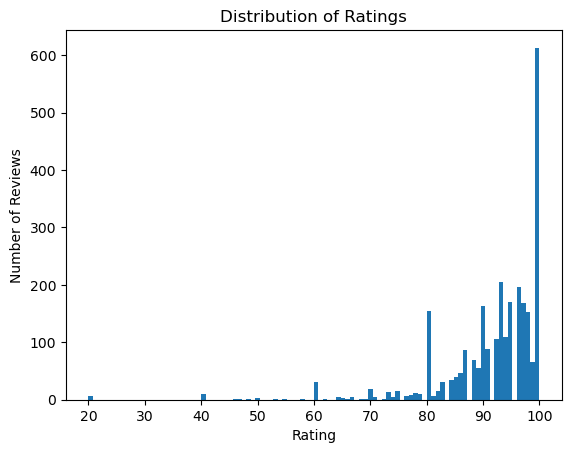

In [31]:
plt.hist(aggregated_review_df['review_scores_rating'], bins=100)
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Ratings')
plt.show()


In [13]:
aggregated_review_df
def is_positive(x):
    if x >= 90:
        return 1
    else:
        return 0

aggregated_review_df['positive'] = aggregated_review_df['review_scores_rating'].apply(is_positive)

In [14]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB

In [15]:
models = [
    BernoulliNB(),
    MultinomialNB(),
    KNeighborsClassifier(),
    RandomForestClassifier(),
]

classifier_Names = ['BernoulliNB', 'MultinomialNB',
                    'KNeighborsClassifier', 'RandomForestClassifier']

In [16]:
counts = aggregated_review_df['positive'].value_counts()
print(counts)

1    2037
0     711
Name: positive, dtype: int64


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(aggregated_review_df['comments'])
y = aggregated_review_df['positive']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [18]:
from sklearn.metrics import accuracy_score


for name, model in zip(classifier_Names, models):
    model.fit(X_train, y_train)
    pre_labels = model.predict(X_test)
    score = accuracy_score(y_test, pre_labels)
    print('%s: %.2f' % (name, score))

BernoulliNB: 0.73
MultinomialNB: 0.74
KNeighborsClassifier: 0.70
RandomForestClassifier: 0.76


In [19]:
from sklearn.naive_bayes import MultinomialNB
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(aggregated_review_df['comments'])
y = aggregated_review_df['positive']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [20]:
from sklearn import metrics
own_model_result = model.predict(X_test)
print(metrics.classification_report(y_test, own_model_result))

              precision    recall  f1-score   support

           0       1.00      0.16      0.28       140
           1       0.78      1.00      0.88       410

    accuracy                           0.79       550
   macro avg       0.89      0.58      0.58       550
weighted avg       0.83      0.79      0.72       550



In [21]:
X_res = vectorizer.fit_transform(aggregated_review_df['comments'])
predictions = [round(i[1], 5) for i in model.predict_proba(X_res)]
aggregated_review_df['predict_positive'] = predictions

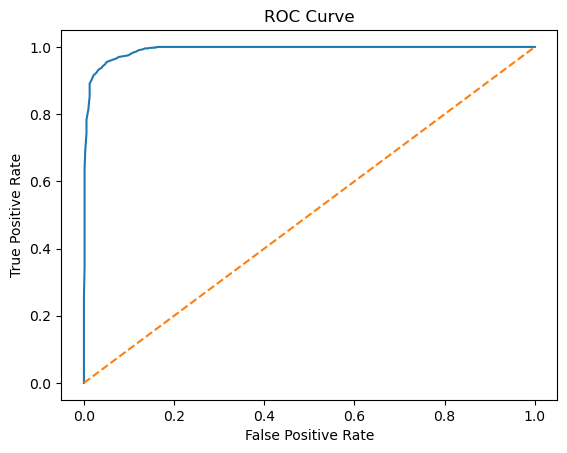

0.9915152657551196


In [36]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
fpr, tpr, thresholds = roc_curve(aggregated_review_df['positive'], aggregated_review_df['predict_positive'])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

auc = roc_auc_score(aggregated_review_df['positive'], aggregated_review_df['predict_positive'])
print(auc)

In [23]:
X_sep = vectorizer.transform(review_df['comments'])
prediction_sep = model.predict(X_sep)
review_df['score'] = prediction_sep

In [24]:
counts = review_df['score'].value_counts()
print(counts)

1    63186
0      718
Name: score, dtype: int64


In [25]:
review_df_counts_listing = review_df.groupby("listing_id")["score"].mean()
review_df_counts_listing = review_df_counts_listing.reset_index()
review_df_counts_listing = review_df_counts_listing.rename(columns={"score": "ratio"})
review_df_counts_listing

,listing_id,ratio
0,3353,1.0
1,5506,1.0
2,6695,1.0
3,6976,1.0
4,8792,1.0
...,...,...
2800,14813006,1.0
2801,14823724,1.0
2802,14842237,1.0
2803,14843050,1.0


In [26]:
review_df_ratios_reviewer = review_df.assign(score=lambda x: x["score"].astype(bool))
review_df_ratios_reviewer = review_df_ratios_reviewer.groupby("reviewer_id")["score"].mean()
review_df_ratios_reviewer = review_df_ratios_reviewer.reset_index()
review_df_ratios_reviewer = review_df_ratios_reviewer.rename(columns={"score": "ratio"})
review_df_ratios_reviewer["ratio"] = review_df_ratios_reviewer["ratio"].astype(int)

In [27]:
review_df_ratios_reviewer

,reviewer_id,ratio
0,143,1
1,322,1
2,933,1
3,1960,1
4,2237,1
...,...,...
59713,92877330,1
59714,93000637,1
59715,93041229,1
59716,93113474,1


In [28]:
review_df = pd.merge(review_df, listings_df[["listing_id", "description"]], on="listing_id")
review_df

,listing_id,id,date,reviewer_id,reviewer_name,comments,score,description
0,1178162,4724140,2013-05-21,4298113,Olivier,my stay at islams place was really cool good l...,1,Great Boston Location conveniently located nea...
1,1178162,4869189,2013-05-29,6452964,Charlotte,great location airport city great amenities in...,1,Great Boston Location conveniently located nea...
2,1178162,5003196,2013-06-06,6449554,Sebastian,we really enjoyed our stay at islams house fro...,1,Great Boston Location conveniently located nea...
3,1178162,5150351,2013-06-15,2215611,Marine,room was nice clean were commodities very clos...,1,Great Boston Location conveniently located nea...
4,1178162,5171140,2013-06-16,6848427,Andrew,great location 5 mins walk from airport statio...,1,Great Boston Location conveniently located nea...
...,...,...,...,...,...,...,...,...
63899,7462268,79199165,2016-06-11,66618882,Darci,wonderful location bus stop right at corner bu...,1,"My place is close to Harvard Business School, ..."
63900,7462268,83640094,2016-07-03,40052513,Steve,joe was on his way jamaica be married on last ...,1,"My place is close to Harvard Business School, ..."
63901,7462268,85797088,2016-07-13,77129134,Nick,room was very clean were bathrooms kitchen bed...,1,"My place is close to Harvard Business School, ..."
63902,7462268,97264637,2016-08-26,15799803,Vid,staying in lower allston at joe nancys place w...,1,"My place is close to Harvard Business School, ..."


In [29]:
# import pandas as pd
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.metrics.pairwise import cosine_similarity
# import numpy as np

# df = review_df.loc[review_df["score"] == 1]
# X = vectorizer.fit_transform(df["comments"] + df["description_x"])

# similarity = cosine_similarity(X)
# most_similar = np.argmax(similarity, axis=1)
# recommendations = df.iloc[most_similar]["listing_id"]


In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def recommend(item_descriptions, user_ratings):
  item_vectors = vectorizer.fit_transform(item_descriptions)
  user_vector = vectorizer.transform([user_ratings])
  sim_scores = cosine_similarity(user_vector, item_vectors)
  sim_scores = sim_scores.flatten()
  sim_scores_sorted_indices = sim_scores.argsort()[::-1]
  k = 10
  return sim_scores_sorted_indices[:k]

item_descriptions = review_df["description"]
user_ratings = review_df["score"]
recommended_item_indices = recommend(item_descriptions, user_ratings)


AttributeError: 'Series' object has no attribute 'lower'